In [2]:
%matplotlib widget

In [163]:
"""
Created on Mon Oct 12 14:30:00 2020

@author: abhishekroy
"""

from dataclasses import dataclass
from typing import List, Tuple, Set, Optional, Literal
import numpy as np

Line = Tuple[int,int,int,int]
Box = Tuple[int,int]

@dataclass
class Board:
    """
    Data describing the state of a square board at some stage in the game. 

    size  --> number of boxes in each row and column. Total boxes = size*size
    lines --> lines on the board. each line (i,j,r,s) goes from (i,j) to (r,s)
              IMPORTANT: ensure that i<=j and r<=s so lines go rightwards
                         and upwards
    red_boxes  --> Boxes made by the red player (moves first)
    blue_boxes --> Boxes made by the blue player (moves second)
    """
    size: int
    
    lines: List[Line] = None  
    red_boxes: Optional[List[Box]] = None
    blue_boxes: Optional[List[Box]] = None

    def __post_init__(self):
        self.lines = [] if self.lines is None else self.lines
        self.red_boxes = [] if self.red_boxes is None else self.red_boxes
        self.blue_boxes = [] if self.blue_boxes is None else self.blue_boxes

    def __copy__(self):
        return Board(size=self.size,lines=self.lines.copy(),red_boxes=self.red_boxes.copy(),
                     blue_boxes=self.blue_boxes)
    

@dataclass
class Game:
    size: int
    start: Optional[Board]
    moves: List[List[Line]]


In [164]:
def isvalidboard(board:Board)->bool:
    """
    Check if the lines and red/blue boxes on the board are valid.
    """
    n = board.size
    valid = all((
                0<=i<=n and 0<=j<=n and 0<=r<=n and 0<=s<=n and\
                abs(i-j)+abs(r-s) == 1 \
                    for (i,j,r,s) in board.lines
                ))
    
    if board.red_boxes and board.blue_boxes:
        boxes = set(getboxes(board))
        valid = valid and all((b in boxes for b in board.red_boxes)) and\
                          all((b in boxes for b in board.blue_boxes)) and\
                          len(boxes) == len(board.red_boxes) + len(board.blue_boxes)
    return valid

In [165]:
def getboxes(board:Board)->List[Tuple[int,int]]:
    """
    Returns list of the bottom-left corners of all filled boxes.  
    """
    lines = board.lines
    boxes = []
    for i in range(board.size):
        for j in range(board.size):
            if (i,j,i+1,j) in lines and\
               (i,j+1,i+1,j+1) in lines and\
               (i,j,i,j+1) in lines and\
               (i+1,j,i+1,j+1) in lines:
                boxes.append((i,j)) 
               
    return boxes


def countboxes(board:Board)->int:
    """
    Returns number of filled boxes on the board.
    """
    return len(getboxes(board))


def isboxfilled(board:Board, box:Tuple[int,int])->bool:
    """
    Given the bottom-left corner of a box, check if it is filled (all lines are 
    on the board).
    """
    lines = board.lines
    i,j = box
    return (i,j,i+1,j) in lines and (i,j+1,i+1,j+1) in lines and\
            (i,j,i,j+1) in lines and (i+1,j,i+1,j+1) in lines


def getnewboxes(lines:List[Line], line:Line)->List[Tuple[int]]:
    """
    Returns list of NEW boxes created by adding one NEW *line* to the *lines* 
    that have already been drawn. 
    Boxes are denoted by the bottom-left corner.
    """
    if line in lines:
        return []

    i,j,r,s = line

    above = [(i,j+1,i+1,j+1), (i,j,i,j+1), (i+1,j,i+1,j+1)]
    below = [(i,j-1,i,j), (i,j-1,i+1,j-1), (i+1,j-1,i+1,j)]
    right = [(i,j+1,i+1,j+1), (i,j,i+1,j), (i+1,j,i+1,j+1)]
    left  = [(i-1,j,i,j), (i-1,j,i-1,j+1), (i-1,j+1,i,j+1)]
    
    options = ()
    if r-i == 1:
        options = ((above, (i,j)), 
                   (below, (i,j-1)))
    elif s-j == 1:
        options = ((right, (i,j)),
                   (left,  (i-1,j))) 

    newboxes = [box for (remaining, box) in options if all((l in lines for l in remaining))]
    return newboxes


In [161]:
def isvalidmove(board:Board, move:List[Line])->bool:
    """
    Checks validity of a move. A move is a list of lines made a player
    in his/her turn.

    If a line creates a filled box then there must a next line and so on, 
    until either no box is created or the game ends.
    """
    n = board.size
    #A move can be empty iff there are no more lines to made
    if not move and len(board.lines) < 2*n*(n+1):
        return False
    #No repeated lines 
    if any((line in board.lines for line in move)) or\
        len(set(move)) != len(move):
            return False
    
    #Each of the lines in the move before the last one, must add a new box
    total_lines = list(board.lines) + move
    for i in range(len(board.lines), len(total_lines)-1):
        if not getnewboxes(total_lines[:i], total_lines[i]):
            return False
    
    #The last line must either:
    #   1. Be the last line of the game
    #   2. NOT create a new box
    if len(total_lines) < 2*n*(n+1) and getnewboxes(total_lines[:-1], move[-1]):
        return False
    
    return True

In [92]:
from copy import copy

def makemove(board:Board, move:List[Line], player:Literal["red","blue"], 
             copyboard=True, checkmove=True)->Board:
    """
    Make a move i.e. add its line(s) to the board.
    Returns a new board or changes board directly based on *copyboard*.
    """
    if copyboard:
        board = copy(board)
    if checkmove and not isvalidmove(board, move):
        print(f"Invalid {move} for {board}")
        return board
    
    old_boxes = getboxes(board)
    board.lines += move
    new_boxes = getboxes(board)
    added_boxes = [b for b in new_boxes if b not in old_boxes]
    if player == "red":
        board.red_boxes += added_boxes
    else:
        board.blue_boxes += added_boxes
    
    return board

In [166]:
def get_all_lines(n:int)->List[Line]:
    """
    Returns list of all 2n(n+1) lines possible on an n X n board.
    """
    all_lines = [(i,j,i+1,j) for i in range(n) for j in range(n)]
    all_lines += [(i,j,i,j+1) for i in range(n) for j in range(n)]
    all_lines += [(n,i,n,i+1) for i in range(n)]
    all_lines += [(i,n,i+1,n) for i in range(n)]
    
    all_lines = [(min(i,r),min(j,s),max(i,r),max(j,s)) for (i,j,r,s) in all_lines]
    return all_lines

In [151]:
import random

def make_random_move(board:Board)->List[Line]:
    n = board.size
    #All lines have already been made
    if len(board.lines) >= 2*n*(n+1):
        return []
    
    options = [l for l in get_all_lines(n) if l not in board.lines]
    line = random.choice(options)
    move = [line]
    options.remove(line)

    #As long as the line makes a box and is not the last line,
    #make another line
    while options and getnewboxes(board.lines+move[:-1], line):
        line = random.choice(options)
        move += [line]
        options.remove(line)

    if not isvalidmove(board, move):
        print("Oops",board,move)

    return move

In [152]:
b = Board(size=2)
bl = [b]
m = make_random_move(b)
player = 0
while m:
    print(b,m)
    b = makemove(b,m,("red","blue")[player])
    bl += [b]
    m = make_random_move(b)
    player = 1-player
    

Board(size=2, lines=[], red_boxes=[], blue_boxes=[]) [(1, 1, 1, 2)]
Board(size=2, lines=[(1, 1, 1, 2)], red_boxes=[], blue_boxes=[]) [(2, 1, 2, 2)]
Board(size=2, lines=[(1, 1, 1, 2), (2, 1, 2, 2)], red_boxes=[], blue_boxes=[]) [(1, 1, 2, 1)]
Board(size=2, lines=[(1, 1, 1, 2), (2, 1, 2, 2), (1, 1, 2, 1)], red_boxes=[], blue_boxes=[]) [(1, 0, 1, 1)]
Board(size=2, lines=[(1, 1, 1, 2), (2, 1, 2, 2), (1, 1, 2, 1), (1, 0, 1, 1)], red_boxes=[], blue_boxes=[]) [(0, 0, 1, 0)]
Board(size=2, lines=[(1, 1, 1, 2), (2, 1, 2, 2), (1, 1, 2, 1), (1, 0, 1, 1), (0, 0, 1, 0)], red_boxes=[], blue_boxes=[]) [(0, 1, 1, 1)]
Board(size=2, lines=[(1, 1, 1, 2), (2, 1, 2, 2), (1, 1, 2, 1), (1, 0, 1, 1), (0, 0, 1, 0), (0, 1, 1, 1)], red_boxes=[], blue_boxes=[]) [(0, 1, 0, 2)]
Board(size=2, lines=[(1, 1, 1, 2), (2, 1, 2, 2), (1, 1, 2, 1), (1, 0, 1, 1), (0, 0, 1, 0), (0, 1, 1, 1), (0, 1, 0, 2)], red_boxes=[], blue_boxes=[]) [(0, 0, 0, 1), (1, 0, 2, 0)]
Board(size=2, lines=[(1, 1, 1, 2), (2, 1, 2, 2), (1, 1, 2, 1), (

In [154]:
len(bl)

10

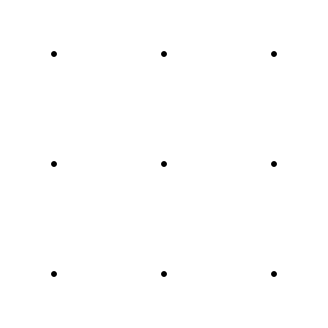

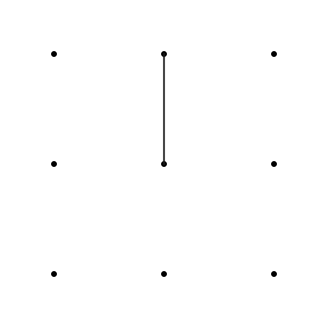

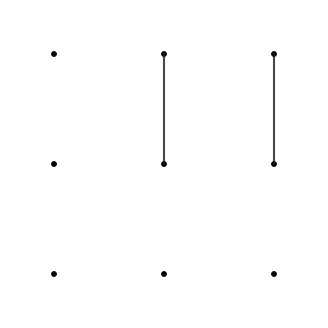

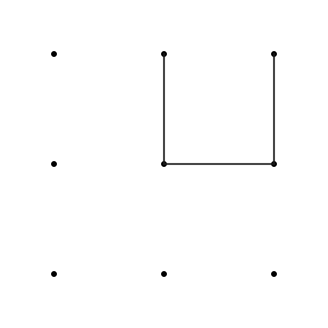

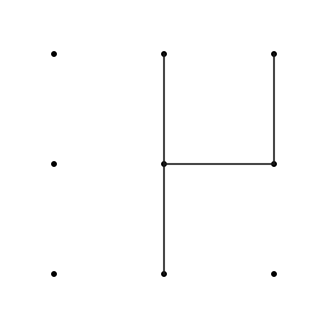

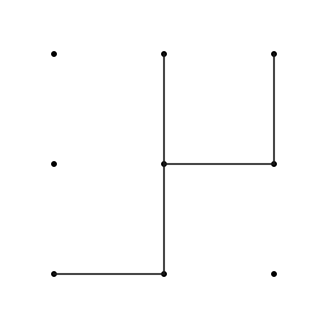

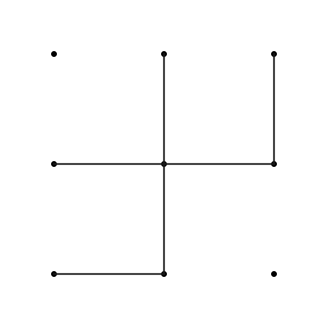

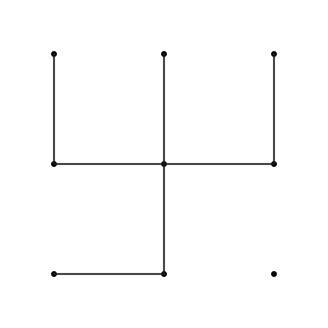

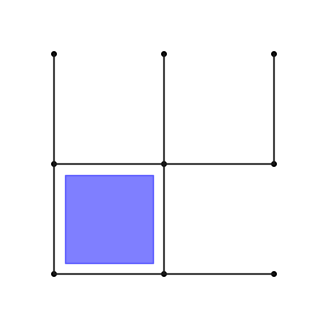

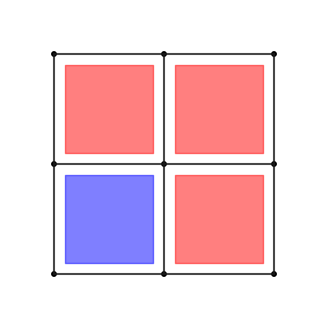

In [153]:
%matplotlib inline
from IPython.display import display

ims = [drawboard(b) for b in bl]
display(*ims)

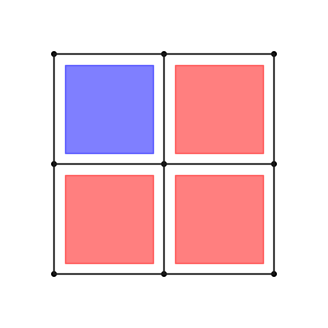

In [150]:
drawboard(bl[-1])

In [32]:
l

(0, 0, 0, 1)

In [31]:
b.lines

[(0, 0, 1, 0),
 (0, 1, 1, 1),
 (1, 0, 2, 0),
 (1, 1, 2, 1),
 (0, 1, 0, 2),
 (1, 0, 1, 1),
 (1, 1, 1, 2),
 (2, 0, 2, 1),
 (2, 1, 2, 2),
 (0, 2, 1, 2),
 (1, 2, 2, 2)]

In [28]:
l

(0, 0, 0, 1)

In [168]:
from matplotlib.patches import Circle, Rectangle
from matplotlib.lines import Line2D
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt

import io
import PIL.Image as Image

## MALAI Challenge - Dots and Boxes

In [184]:
def drawboard(board,size=4):
    '''Draw a board. Requires matplotlib and PIL'''
    fig, ax = plt.subplots()

    fig.set_size_inches(size,size)
    ax.set_ylim(-1.2, 0.2)
    ax.set_xlim(-1.2, 0.2)
    ax.set_aspect('equal')
    ax.set_axis_off()

    patches = []

    ox, oy = (-1,-1)
    n = board.size
    cr = 0.01
    patches = []

    for (i,j,r,s) in board.lines:
        x,y,xx,yy = ox+i/n, oy+j/n, ox+r/n, oy+s/n
        ax.add_artist(Line2D([x, xx], [y, yy],color=(0.1,0.1,0.1,0.8)))

    for i in range(n+1):
        for j in range(n+1):
            center = (ox+i/n, oy+j/n)
            circle = Circle(center, cr)
            circle.set_color([0,0,0,1])
            patches.append(circle)

    for i in range(n):
        for j in range(n):
            if isboxfilled(board, (i,j)):
                if (i,j) in board.red_boxes:
                    color = (1,0,0,0.5)
                elif (i,j) in board.blue_boxes:
                    color = (0,0,1,0.5)
                else:
                    color = (0,0,0,0.5)
                rect = Rectangle((ox+i/n+0.1/n, oy+j/n+0.1/n), 0.8/n, 0.8/n,color=color)
                patches.append(rect)

    for i in range(n+1):
        for center in [(ox+i/n,oy-0.1), (ox-0.1,oy+i/n)]:
            ax.annotate(str(i), center, fontsize=12, ha='center',va='center',
                    weight="light")

    p = PatchCollection(patches, match_original=True)
    ax.add_collection(p)

    buf = io.BytesIO()
    fig.savefig(buf, format='png',bbox_inches='tight')
    buf.seek(0)
    im = Image.open(buf)
    plt.close(fig) #don't display image
    return im

### Testing

In [178]:
n=2
lines = get_all_lines(n)
b = Board(size=2,lines=lines.copy())

for l in lines:
    b.lines.remove(l)
    (i,j,r,s) = l
    print(countboxes(b), getnewboxes(b,l))
    print(all((box not in getboxes(b) for box in getnewboxes(b,l))))
    b.lines.append(l)

TypeError: argument of type 'Board' is not iterable

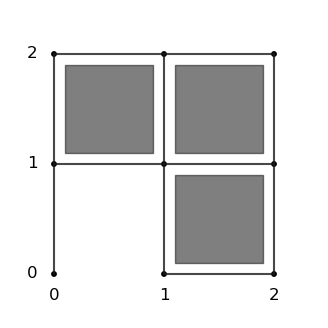

In [185]:
drawboard(b)

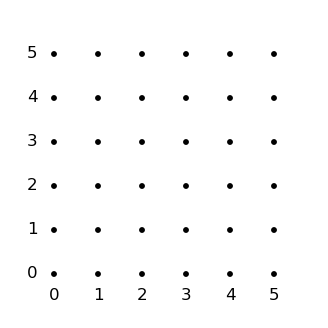

In [186]:
bb = Board(size=5)
drawboard(bb)

In [74]:
isvalidmove(b,[(1,1,1,2)])

True

In [204]:
import random
from copy import copy

ll = get_all_lines(2)
b = Board(2, [], 0, 0)
bb = []
while ll:
    l = random.choice(ll)
    ll.remove(l)
    b.lines.append(l)
    bb.append(copy(b))

In [205]:
ims = [drawboard(b) for b in bb]

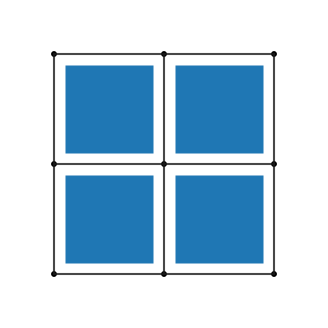

In [213]:
ims[11]

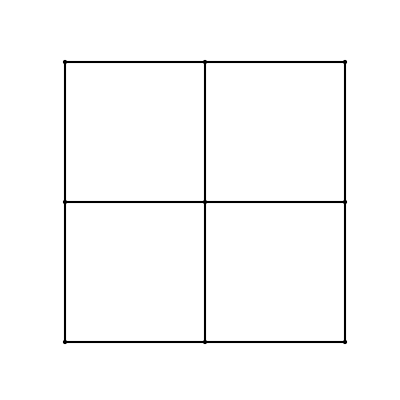

(0, 2, 1, 2)
(1, 2, 2, 2)
(2, 1, 2, 2)
(1, 1, 2, 1)
(0, 1, 1, 1)
removed  (0, 1, 1, 1)
(1, 0, 1, 1)
(0, 0, 1, 0)
(0, 0, 0, 1)
(0, 1, 0, 2)


In [133]:
%matplotlib widget

fig, ax = plt.subplots()
n=2
size=4
fig.set_size_inches(size,size)
ax.set_ylim(-0.1, n+0.1)
ax.set_xlim(-0.1, n+0.1)
ax.set_aspect('equal')
ax.set_axis_off()


cr = 0.01
patches = []
black = [0,0,0,1]

for i in range(n):
    for j in range(n):
        ax.add_artist(Line2D([i,i+1], [j, j],color=black,picker=6, pickradius=3))
        ax.add_artist(Line2D([i,i], [j, j+1],color=black,picker=6, pickradius=3))

for i in range(n):
        ax.add_artist(Line2D([n,n], [i, i+1],color=black,picker=6, pickradius=3))
        ax.add_artist(Line2D([i,i+1], [n, n],color=black,picker=6, pickradius=3))

for i in range(n+1):
    for j in range(n+1):
        center = (i, j)
        circle = Circle(center, cr)
        circle.set_color([0,0,0,1])
        patches.append(circle)

p = PatchCollection(patches, match_original=True)
ax.add_collection(p)

clicklines = set()
def onpick(event):
    thisline = event.artist
    xdata = thisline.get_xdata()
    ydata = thisline.get_ydata()
    l = (xdata[0],ydata[0],xdata[1],ydata[1])
    if l not in clicklines:
        thisline.set_color((0,0,1))
        clicklines.add(l)
        print(l)
    else:
        thisline.set_color(black)
        clicklines.remove(l)
        print("removed ",l)
        

fig.canvas.mpl_connect('pick_event', onpick)

plt.show()


In [135]:
len(clicklines)

8

In [136]:
bb=Board(2,lines=clicklines)

In [137]:
getnewboxes(bb.lines,(0,1,1,1))

[(0, 0)]

In [138]:
isvalidmove(bb, [(0,1,1,1)])

False